#1. Imports & Envierment Setup

In [ ]:
!pip install torch torchvision torchaudio
!pip install lightning

In [ ]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from PIL import Image
from tqdm import tqdm
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from pytorch_lightning import Trainer
import itertools
from pytorch_lightning.callbacks import EarlyStopping
import time
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#2. Preprocess the Data

In [ ]:
class DataLoader(object):
    """
    Class for loading data from image files into pickle file and save it to the drive
    """

    def __init__(self, data_path, output_path):
        self.data_path = data_path
        self.output_path = output_path

    def _open_image(self, path):
        """
        Using the Image library we open the image in the given path. The path must lead to a .jpg file.
        We then resize it to 105x105 like in the paper (the dataset contains 250x250 images.)

        Returns the image as a numpy array.
        """
        image = Image.open(path)
        image = image.resize((105, 105))
        data = np.asarray(image)
        data = np.array(data, dtype='float64')
        return data

    def convert_image_to_array(self, person, image_num, data_path, predict=False):
        """
        Given a person, image number and datapath, returns a numpy array which represents the image.
        predict - whether this function is called during training or testing. If called when training, we must reshape
        the images since the given dataset is not in the correct dimensions.
        """
        max_zeros = 4
        image_num = '0' * max_zeros + image_num
        image_num = image_num[-max_zeros:]
        image_path = os.path.join(data_path, 'lfw2', person, f'{person}_{image_num}.jpg')
        image_data = self._open_image(image_path)
        if not predict:
            image_data = image_data.reshape(105,105, 1)
        return image_data

    def load(self, set_name):
        """
        Writes into the given output_path the images from the data_path.
        dataset_type = train or test
        """
        file_path = os.path.join(self.data_path, 'splits', f'{set_name}.txt')
        print(file_path)
        print('Loading dataset...')
        x_first = []
        x_second = []
        y = []
        names = []
        with open(file_path, 'r') as file:
            lines = file.readlines()
        for line in tqdm.tqdm(lines):
            line = line.split()
            if len(line) == 4:  # Class 0 - non-identical
                names.append(line)
                first_person_name, first_image_num, second_person_name, second_image_num = line[0], line[1], line[2], line[3]
                first_image = self.convert_image_to_array(person=first_person_name, image_num=first_image_num, data_path=self.data_path)
                second_image = self.convert_image_to_array(person=second_person_name, image_num=second_image_num, data_path=self.data_path)
                x_first.append(first_image)
                x_second.append(second_image)
                y.append(0)
            elif len(line) == 3:  # Class 1 - identical
                names.append(line)
                person_name, first_image_num, second_image_num = line[0], line[1], line[2]
                first_image = self.convert_image_to_array(person=person_name, image_num=first_image_num, data_path=self.data_path)
                second_image = self.convert_image_to_array(person=person_name, image_num=second_image_num, data_path=self.data_path)
                x_first.append(first_image)
                x_second.append(second_image)
                y.append(1)
            elif len(line) == 1:
                print(f'line with a single value: {line}')

        print('Done loading dataset')
        with open(self.output_path, 'wb') as f:
            pickle.dump([[x_first, x_second], y, names], f)

In [ ]:
def load_data_to_pickles(data_path, train_path, test_path, train_name, test_name):
  # Check if the files exist and if not loads them using the DataLoader class
  if not  os.path.exists(train_path):
      print("Train file not accessible, loading the train file...")
      loader = DataLoader(data_path=data_path, output_path=train_path)
      loader.load(set_name=train_name)
  else:
      print("Train pickle file already exists")

  if not  os.path.exists(test_path):
      print("Test file not accessible, loading the test file...")
      loader = DataLoader(data_path=data_path, output_path=test_path)
      loader.load(set_name=test_name)
  else:
      print("Test pickle file already exists")

#3. Siamese Neural Network

### Network Setup

In [ ]:
class SiameseNetworkPL(pl.LightningModule):
    def __init__(self, input_shape, dropout_rate=0.4, learning_rate= 0.0005, weight_decay=0.0002,batch_size=32, data_path=None, data_test_path=None, seed=222):
        super(SiameseNetworkPL, self).__init__()
        self.save_hyperparameters()

        # Model architecture
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=64, kernel_size=10, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1)

        self.data_path = data_path
        self.data_test_path = data_test_path
        self.batch_size = batch_size
        self.seed = seed
        self.weight_decay = weight_decay

        # save all the metrics
        self.TrainLossEs = []
        self.ValLossEs = []
        self.TrainAcc = []
        self.ValAcc = []

    def forward_one_side(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = torch.sigmoid(self.fc1(x))
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one_side(x1)
        out2 = self.forward_one_side(x2)
        dist = torch.abs(out1 - out2)
        out = torch.sigmoid(self.fc2(dist))
        return out

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.weight_decay)
        return optimizer

    def training_step(self, batch, batch_idx):
        x1, x2, y = batch
        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        y_hat = self(x1, x2).squeeze()
        loss = F.binary_cross_entropy(y_hat, y)
        acc = ((y_hat > 0.5) == y).float().mean()
        self.TrainLossEs.append(loss.item())
        self.TrainAcc.append(acc.item())
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return {'loss': loss, 'acc': acc}

    def validation_step(self, batch, batch_idx):
        x1, x2, y = batch
        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        y_hat = self(x1, x2).squeeze()
        loss = F.binary_cross_entropy(y_hat, y)
        acc = ((y_hat > 0.5) == y).float().mean()
        self.ValLossEs.append(loss.item())
        self.ValAcc.append(acc.item())
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return {'loss': loss, 'acc': acc}

    def test_step(self, batch, batch_idx):
        x1, x2, y = batch
        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        y_hat = self(x1, x2).squeeze()
        loss = F.binary_cross_entropy(y_hat, y)
        acc = ((y_hat > 0.5) == y).float().mean()
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'test_loss': loss, 'test_acc': acc}

    def setup(self, stage=None):
        if self.data_path:
            with open(self.data_path, 'rb') as f:
                data = pickle.load(f)
            x_first, x_second, y = data[0][0], data[0][1], data[1]

            x_first = torch.tensor(x_first, dtype=torch.float32)
            x_second = torch.tensor(x_second, dtype=torch.float32)
            y = torch.tensor(y, dtype=torch.float32)

            x_first_train, x_first_val, x_second_train, x_second_val, y_train, y_val = train_test_split(x_first, x_second, y, test_size=0.2, random_state=self.seed)

            self.train_dataset = TensorDataset(x_first_train, x_second_train, y_train)
            self.val_dataset = TensorDataset(x_first_val, x_second_val, y_val)

        if self.data_test_path:
            with open(self.data_test_path, 'rb') as f:
                test_data = pickle.load(f)
            x_first_test, x_second_test, y_test = test_data[0][0], test_data[0][1], test_data[1]

            x_first_test = torch.tensor(x_first_test, dtype=torch.float32)
            x_second_test = torch.tensor(x_second_test, dtype=torch.float32)
            y_test = torch.tensor(y_test, dtype=torch.float32)

            self.test_dataset = TensorDataset(x_first_test, x_second_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def get_train_loss(self):
        return self.TrainLossEs

    def get_val_loss(self):
        return self.ValLossEs

    def get_train_acc(self):
        return self.TrainAcc

    def get_val_acc(self):
        return self.ValAcc

    def predict_test_data(self, dataloader):
        self.eval()  # Set the model to evaluation mode
        predictions, labels, probabilities = [], [], []
        with torch.no_grad():  # Disable gradient computation
            for batch in dataloader:
                x1, x2, y = batch
                x1 = x1.permute(0, 3, 1, 2)  # Adjust dimensions if necessary
                x2 = x2.permute(0, 3, 1, 2)  # Adjust dimensions if necessary
                y_hat = self(x1, x2).squeeze()  # Get the model's predictions
                prob = y_hat  # Since y_hat is the output after sigmoid, it can be considered as probability
                pred = (prob > 0.5).float()  # Classify as 0 or 1 based on threshold 0.5

                predictions.extend(pred.tolist())
                labels.extend(y.tolist())
                probabilities.extend(prob.tolist())

        return predictions, labels, probabilities


In [ ]:
def grid_search_hyperparameters(input_shape, data_path, seed=222):
    """
    This function performs a grid search on the parameters to find the best combination
    """
    # Define the hyperparameters to search over
    learning_rates = [0.05, 0.005, 0.0005]
    epochs = [5, 10, 15]
    batch_sizes = [16, 32, 64]
    dropout_rates = [0.2, 0.4, 0.5]
    weight_decays = [0.0002]

    # Dictionary to store the results
    results = {}

    # Iterate over all combinations of hyperparameters
    for lr, epoch, batch_size, weight_decay, dropout_rate in itertools.product(learning_rates, epochs, batch_sizes, weight_decays, dropout_rates):
        # Initialize the model with the current set of hyperparameters
        early_stop_callback = EarlyStopping(monitor='val_acc', patience=5, mode='max')
        model = SiameseNetworkPL(input_shape=input_shape, dropout_rate=dropout_rate, learning_rate=lr, weight_decay=weight_decay, data_path=data_path, batch_size=batch_size, seed=seed)

        # Initialize the trainer with the current epoch setting, disable default checkpointing, and add the EarlyStopping callback
        trainer = Trainer(max_epochs=epoch, callbacks=[early_stop_callback])

        # Train the model
        trainer.fit(model)

        # Retrieve the accuracy from the logged metrics
        val_acc = trainer.callback_metrics['val_acc'].item()
        train_acc = trainer.callback_metrics['train_acc'].item()

        # Store the results
        key = f"LR: {lr}, Epochs: {epoch}, Batch Size: {batch_size}, Weight Decay: {weight_decay}, Dropout Rate: {dropout_rate}"
        results[key] = {'Train Accuracy': train_acc, 'Validation Accuracy': val_acc}

    return results

In [ ]:
def run_grid(train_path, grid_path):
    """
    This function performs a grid search function or reads it from a pickle file if already exists
    """
    # Check if the file exists and if not, preforn the grid search
    if not os.path.exists(grid_path):
        # Perform the grid search
        results = grid_search_hyperparameters(input_shape=(1, 105, 105), data_path = train_path)
        with open(grid_path, 'wb') as f:
          pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        print("Grid pickle file already exists")
        with open(grid_path, 'rb') as f:
          results = pickle.load(f)

    return results

In [ ]:
def get_best_parameters(results):
  """
  returns the parameters that got the best validation accuracy from the grid search
  """
  # Find the key with the highest 'Validation Accuracy'
  best_params_key = max(results.keys(), key=lambda x: results[x]['Validation Accuracy'])

  # Extract numerical values from the best_params_key string
  # The format of the key is "LR: value, Epochs: value, Batch Size: value, Weight Decay: value, Dropout Rate: value"
  params_list = best_params_key.split(", ")
  params_dict = {}
  for param in params_list:
      key, value = param.split(": ")
      params_dict[key] = float(value) if key != "Epochs" and key != "Batch Size" else int(value)

  # Extract individual parameters
  LR = params_dict['LR']
  Epochs = params_dict['Epochs']
  Batch_Size = params_dict['Batch Size']
  Weight_Decay = params_dict['Weight Decay']
  Dropout_Rate = params_dict['Dropout Rate']

  return LR, Epochs, Batch_Size, Weight_Decay, Dropout_Rate

### Evaluate the network

In [ ]:
def train_and_evaluate(dropout_rate, learning_rate, data_path, data_test_path, batch_size, epochs, seed=222, weight_decay=0.0002):
    """
    Trains and evaluates a Siamese Network model using PyTorch Lightning.

    Parameters:
    - dropout_rate (float): Dropout rate for the model to prevent overfitting.
    - learning_rate (float): Learning rate for the optimizer.
    - data_path (str): File path to the training dataset.
    - data_test_path (str): File path to the test dataset.
    - batch_size (int): Batch size for training and evaluation.
    - epochs (int): Number of epochs to train the model.
    - seed (int, optional): Seed for random number generation for reproducibility. Defaults to 222.
    - weight_decay (float, optional): Weight decay (L2 penalty) for regularization. Defaults to 0.0002.

    Returns:
    - model (SiameseNetworkPL): The trained Siamese Network model.
    - metrics (dict): A dictionary containing training, validation, and test metrics.
    """

    # Initialize the model with the provided parameters
    model = SiameseNetworkPL(input_shape=(1, 105, 105), dropout_rate=dropout_rate, learning_rate=learning_rate, weight_decay=weight_decay, data_path=data_path, data_test_path=data_test_path, batch_size=batch_size, seed=seed)

    # Setup EarlyStopping
    early_stop_callback = EarlyStopping(monitor='val_acc', patience=5, mode='max')

    # Initialize the trainer
    trainer = Trainer(max_epochs=epochs, callbacks=[early_stop_callback])

    # Start timing
    start_time = time.time()

    # Train the model
    trainer.fit(model)

    # Measure the convergence time
    convergence_time = time.time() - start_time

    # Retrieve metrics from the trainer's logged metrics
    train_loss = trainer.logged_metrics.get('train_loss')
    val_loss = trainer.logged_metrics.get('val_loss')
    train_acc = trainer.logged_metrics.get('train_acc')
    val_acc = trainer.logged_metrics.get('val_acc')


    # Evaluate the model on the test set
    test_result = trainer.test(model, dataloaders=model.test_dataloader())
    test_loss = test_result[0]['test_loss']
    test_acc = test_result[0]['test_acc']

    # Print metrics
    print(f"Final Loss on train set: {train_loss:.3f}")
    print(f"Final Loss on validation set: {val_loss:.3f}")
    print(f"Final Loss on Testing set: {test_loss:.3f}")
    print(f"Accuracy on train set: {train_acc:.3f}")
    print(f"Accuracy on validation set: {val_acc:.3f}")
    print(f"Accuracy on Testing set: {test_acc:.3f}")
    print(f"Convergence time: {convergence_time:.3f} seconds")

    metrics = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_loss': test_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'convergence_time': convergence_time
    }
    return model, metrics

In [ ]:
def epoch_array(matric_batch_array, num_epoch):
  """
  The  function calculates the mean matric value fo each epoch
  """
  res = []
  for i in np.array_split(matric_batch_array,num_epoch):
    res.append(float(np.mean(i)))
  return res

In [ ]:
def plot_acc_and_loss(model, num_epoch):
  """
  Helper function to plot the graphs
  """

  train_losses = epoch_array(model.get_train_loss(), num_epoch)
  val_losses = epoch_array(model.get_val_loss(), num_epoch)
  train_accs = epoch_array(model.get_train_acc(), num_epoch)
  val_accs = epoch_array(model.get_val_acc(), num_epoch)

  epochs = range(1, num_epoch + 1)

  # Plot training and validation loss
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_losses, '.-', label='Training Loss', color = '#609d9e')
  plt.plot(epochs, val_losses, '.-', label='Validation Loss', color = '#075052')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Plot training and validation accuracy
  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_accs, '.-', label='Training Accuracy', color = '#609d9e')
  plt.plot(epochs, val_accs, '.-', label='Validation Accuracy', color = '#075052')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

### Experimenting Various Parameters

In [ ]:
def experimenting_various_parameters(model, metrics, LR, Epochs, Batch_Size, Weight_Decay, Dropout_Rate, data_path, data_test_path, param_dic_path = None):
    """
    Experiments with various hyperparameters for the Siamese Network model and stores the results.

    Parameters:
    - model: The model class to be used for the experiments.
    - metrics: A dictionary containing the validation and test accuracy of the baseline model.
    - LR (float): The learning rate to be experimented with.
    - Epochs (int): The number of epochs for training.
    - Batch_Size (int): The batch size for training and evaluation.
    - Weight_Decay (float): The weight decay (L2 penalty) for regularization.
    - Dropout_Rate (float): The dropout rate for the model to prevent overfitting.
    - data_path (str): File path to the training dataset.
    - data_test_path (str): File path to the test dataset.
    - param_dic_path (str, optional): Path to save the results of the experiments as a pickle file. If None, results are not saved.

    Returns:
    - results (dict): A dictionary containing the results of the experiments with different hyperparameters.
    """
    if not os.path.exists(param_dic_path):
      LRs = [0.005, 0.05, 0.1]
      LR = [LR]
      Dropout_Rates = [0.2, 0.4]
      Dropout_Rate = [Dropout_Rate]
      Epochs = [Epochs]
      Batch_Size = [Batch_Size]
      Weight_Decay = [Weight_Decay]

      # Dictionary to store the results
      results = {}

      # Iterate over all combinations for different LR hyperparameters
      for lr, epoch, batch_size, weight_decay, dropout_rate in itertools.product(LRs, Epochs, Batch_Size, Weight_Decay, Dropout_Rate):
            model_curr = SiameseNetworkPL(input_shape=(1, 105, 105), dropout_rate=dropout_rate, learning_rate=lr, weight_decay=weight_decay, data_path=data_path, data_test_path=data_test_path, batch_size=batch_size)
            early_stop_callback = EarlyStopping(monitor='val_acc', patience=5, mode='max') # Setup EarlyStopping
            trainer = Trainer(max_epochs=epoch, callbacks=[early_stop_callback])
            trainer.fit(model_curr)
            val_acc = trainer.logged_metrics.get('val_acc')
            test_result = trainer.test(model_curr, dataloaders=model_curr.test_dataloader()) # Evaluate the model on the test set
            test_acc = test_result[0]['test_acc']
            key = f"LR: {lr}, Epochs: {epoch}, Batch Size: {batch_size}, Weight Decay: {weight_decay}, Dropout Rate: {dropout_rate}"
            results[key] = {'Validation Accuracy': val_acc.item(), 'Test Accuracy': test_acc, 'LR': lr}

      # Iterate over all combinations for different Dropout_Rates hyperparameters
      for lr, epoch, batch_size, weight_decay, dropout_rate in itertools.product(LR, Epochs, Batch_Size, Weight_Decay, Dropout_Rates):
            model_curr = SiameseNetworkPL(input_shape=(1, 105, 105), dropout_rate=dropout_rate, learning_rate=lr, weight_decay=weight_decay, data_path=data_path, data_test_path=data_test_path, batch_size=batch_size)
            early_stop_callback = EarlyStopping(monitor='val_acc', patience=5, mode='max') # Setup EarlyStopping
            trainer = Trainer(max_epochs=epoch, callbacks=[early_stop_callback])
            trainer.fit(model_curr)
            val_acc = trainer.logged_metrics.get('val_acc')
            test_result = trainer.test(model_curr, dataloaders=model_curr.test_dataloader()) # Evaluate the model on the test set
            test_acc = test_result[0]['test_acc']
            key = f"LR: {lr}, Epochs: {epoch}, Batch Size: {batch_size}, Weight Decay: {weight_decay}, Dropout Rate: {dropout_rate}"
            results[key] = {'Validation Accuracy': val_acc.item(), 'Test Accuracy': test_acc, 'Dropout_Rate': dropout_rate }

      results[f"LR: {LR}, Epochs: { Epochs}, Batch Size: {Batch_Size}, Weight Decay: {Weight_Decay}, Dropout Rate: {Dropout_Rate}"] = {'Validation Accuracy': metrics['val_acc'], 'Test Accuracy': metrics['test_acc'], 'Dropout_Rate': Dropout_Rate, 'LR':LR }

      with open(param_dic_path, 'wb') as f:
          pickle.dump(results, f)

    else:
      print("Param dic pickle file already exists")
      with open(param_dic_path, 'rb') as f:
        results = pickle.load(f)

    return results

In [ ]:
def initialize_dics(params_acc_dic):
  # Initialize dictionaries to hold the accuracies for plotting
  lr_val_acc = {}
  lr_test_acc = {}
  dropout_val_acc = {}
  dropout_test_acc = {}

  # Extract data
  for key, value in params_acc_dic.items():
      if 'LR' in value:
          lr = value['LR']
          lr_val_acc[lr] = value['Validation Accuracy']
          lr_test_acc[lr] = value['Test Accuracy']
      if 'Dropout_Rate' in value:
          dropout_rate = value['Dropout_Rate']
          dropout_val_acc[dropout_rate] = value['Validation Accuracy']
          dropout_test_acc[dropout_rate] = value['Test Accuracy']
  return lr_val_acc, lr_test_acc, dropout_val_acc, dropout_test_acc

In [ ]:
def plot_acc_by_lr(lr_val_acc, lr_test_acc):
    # Settings for the graphs
    lr_labels = sorted(lr_val_acc.keys())
    x = np.arange(len(lr_labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, [lr_val_acc[lr] for lr in lr_labels], width, label='Validation Accuracy', color='#609d9e')
    rects2 = ax.bar(x + width/2, [lr_test_acc[lr] for lr in lr_labels], width, label='Test Accuracy', color='#075052')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Learning Rate', fontsize=10)
    ax.set_ylabel('Accuracy', fontsize=10)
    ax.set_title('Accuracy by Learning Rate', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([str(lr) for lr in lr_labels], fontsize=8)
    ax.legend(fontsize=9)

    # Manually adding text annotations for bar labels with specific font size
    def add_bar_labels(bars, fontsize=8):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=fontsize)

    add_bar_labels(rects1, fontsize=8)
    add_bar_labels(rects2, fontsize=8)

    fig.tight_layout()

    plt.show()

In [ ]:
def plot_acc_by_dropout( dropout_val_acc, dropout_test_acc):
    dropout_labels = sorted(dropout_val_acc.keys(), key=lambda x: float(x))  # Sort the dropout labels
    x = np.arange(len(dropout_labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, [dropout_val_acc[dr] for dr in dropout_labels], width, label='Validation Accuracy', color='#609d9e')
    rects2 = ax.bar(x + width/2, [dropout_test_acc[dr] for dr in dropout_labels], width, label='Test Accuracy', color='#075052')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Dropout Rate', fontsize=10)
    ax.set_ylabel('Accuracy', fontsize=10)
    ax.set_title('Accuracy by Dropout Rate', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels([str(dr) for dr in dropout_labels], fontsize=8)
    ax.legend(fontsize=9)

    # Set y-axis ticks
    ax.set_ylim(0, 0.8)  # Adjust y-axis to show ticks up to 0.8
    ax.set_yticks(np.arange(0, 0.91, 0.1))  # Set y-ticks to be in intervals of 0.1 up to 0.8

    # Manually adding text annotations for bar labels with specific font size
    def add_bar_labels(bars, fontsize=8):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=fontsize)

    add_bar_labels(rects1, fontsize=8)
    add_bar_labels(rects2, fontsize=8)

    fig.tight_layout()

    plt.show()

### Prediction Labels and Evaluation

In [ ]:
def get_predictions_and_labels(model, classification_results_path):
    """
    this function returns the classification results for the trained model
    """
    if not os.path.exists(classification_results_path):
        predictions, labels, probabilities = model.predict_test_data(model.test_dataloader())
        classification_res = {}
        for i, (pred, label, prob) in enumerate(zip(predictions, labels, probabilities)):
            classification_res[i] = {'Predicted Class': pred, 'ActualClass': label, 'Probability':prob}
        with open(classification_results_path, 'wb') as f:
          pickle.dump(classification_res, f)
    else:
        print("Classification Results pickle file already exists")
        with open(classification_results_path, 'rb') as f:
          classification_res = pickle.load(f)

    return classification_res

In [ ]:
def get_top_predictions(classification_res):
    """
    The function finds the best and worst classification results and returs a dictionery that holds the best TP, TN ,FP, FN
    """
    # Define lambda functions for each condition
    tp_key = lambda x: (classification_res[x]['Probability'] if classification_res[x]['Predicted Class'] == 1 and classification_res[x]['ActualClass'] == 1 else float('-inf'))

    tn_key = lambda x: (classification_res[x]['Probability'] if classification_res[x]['Predicted Class'] == 0 and classification_res[x]['ActualClass'] == 0 else float('inf'))

    fp_key = lambda x: (classification_res[x]['Probability'] if classification_res[x]['Predicted Class'] == 1 and classification_res[x]['ActualClass'] == 0 else float('-inf'))

    fn_key = lambda x: (classification_res[x]['Probability'] if classification_res[x]['Predicted Class'] == 0 and classification_res[x]['ActualClass'] == 1 else float('inf'))

    # Use max function to find the entries with the highest probability for each condition
    tp = max(classification_res, key=tp_key, default=None)
    tn = min(classification_res, key=tn_key, default=None)
    fp = max(classification_res, key=fp_key, default=None)
    fn = min(classification_res, key=fn_key, default=None)

    # Retrieve the actual dictionary entries for TP, TN, FP, FN
    top_predictions = {
        'TP': (tp, classification_res[tp]),
        'TN': (tn, classification_res[tn]),
        'FP': (fp, classification_res[fp]),
        'FN': (fn, classification_res[fn])
    }
    return top_predictions

In [ ]:
def print_top_prediction_names(top_predictions, file_path):
    '''
    The function prints the name and the photo numbers for the top_predictions dictionary values
    '''
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    for category, (index, prediction) in top_predictions.items():
        print(f"{category}: Name = {data[2][index]}, Details = {prediction}")

# 4. Run Experiments

In [ ]:
def run_experiments_and_print_results():
    """
    Runs the full experiments plan and prints the results
    """
    # Experiments Constants
    data_path = '/content/drive/My Drive/Datasets/lfw2' # the data file saved in google drive drive
    train_name = 'pairsDevTrain'
    test_name = 'pairsDevTest'
    grid_results = 'gridSearchResults_big'
    classification_results = 'classificationRes'
    diffrent_param_dic = 'diffrentParamDic'
    train_path = os.path.join(data_path, f'{train_name}.pickle')  # A path for the train file
    test_path = os.path.join(data_path, f'{test_name}.pickle')  # A path for the test file
    grid_path = os.path.join(data_path, f'{grid_results}.pickle') # A path for the grid results file
    classification_results_path = os.path.join(data_path, f'{classification_results}.pickle') # A path for the grid results file
    diffrent_param_dic_path = os.path.join(data_path, f'{diffrent_param_dic}.pickle')  # A path for the parameter dic
    input_shape = (1, 105, 105)

    # Load the dat into pickle files
    load_data_to_pickles(data_path, train_path, test_path, train_name, test_name)

    # Perform a grid search to find the best params for the network
    results = run_grid(train_path, grid_path)
    lr, epochs, batch_size, weight_decay, dropout_rate = get_best_parameters(results)

    # Train and evaluate the model wirh the best chosen params
    model, metrics =  train_and_evaluate(dropout_rate= dropout_rate, learning_rate=lr, weight_decay=weight_decay, epochs = epochs, batch_size= batch_size, data_path= train_path, data_test_path = test_path)
    plot_acc_and_loss(model, epochs)

    # Experimenting various parameters and plotting
    diffrent_params_acc_dic = experimenting_various_parameters(model=model, metrics=metrics, LR=lr, Epochs=epochs, Batch_Size=batch_size, Weight_Decay=weight_decay, Dropout_Rate=dropout_rate, data_path=train_path, data_test_path=test_path, param_dic_path = diffrent_param_dic_path)
    lr_val_acc, lr_test_acc, dropout_val_acc, dropout_test_acc = initialize_dics(diffrent_params_acc_dic)
    plot_acc_by_lr(lr_val_acc, lr_test_acc)
    plot_acc_by_dropout( dropout_val_acc, dropout_test_acc)

    # Get the classification results and evaluate classification preformence
    classification_res = get_predictions_and_labels(model, classification_results_path)
    top_predictions = get_top_predictions(classification_res)
    print_top_prediction_names(top_predictions, test_path)


Train pickle file already exists
Test pickle file already exists
Grid pickle file already exists


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params
-----------------------------------------
0  | conv1   | Conv2d      | 6.5 K 
1  | bn1     | BatchNorm2d | 128   
2  | conv2   | Conv2d      | 401 K 
3  | bn2     | BatchNorm2d | 256   
4  | conv3   | Conv2d      | 262 K 
5  | bn3     | BatchNorm2d | 256   
6  | conv4   | Conv2d      | 524 K 
7  | bn4     | BatchNorm2d | 512   
8  | dropout | Dropout     | 0     
9  | fc1     | Linear      | 37.8 M
10 | fc2     | Linear      | 4.1 K 
-----------------------------------------
39.0 M    Trainable params
0 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6980000138282776     │
│         test_loss         │    0.8238266706466675     │
└───────────────────────────┴───────────────────────────┘

Final Loss on train set: 0.024
Final Loss on validation set: 0.817
Final Loss on Testing set: 0.824
Accuracy on train set: 1.000
Accuracy on validation set: 0.693
Accuracy on Testing set: 0.698
Convergence time: 241.344 seconds


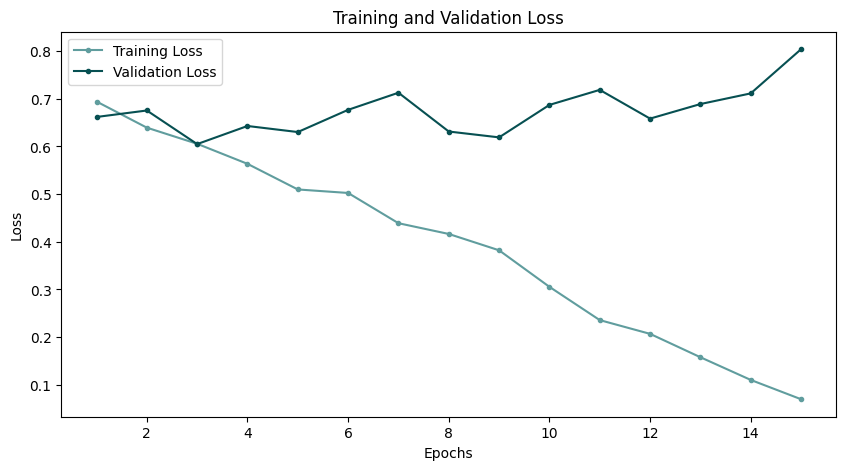

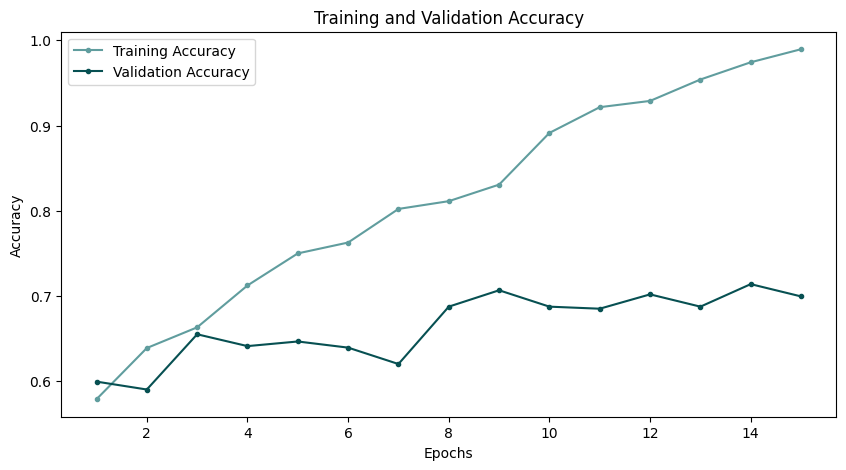

Param dic pickle file already exists


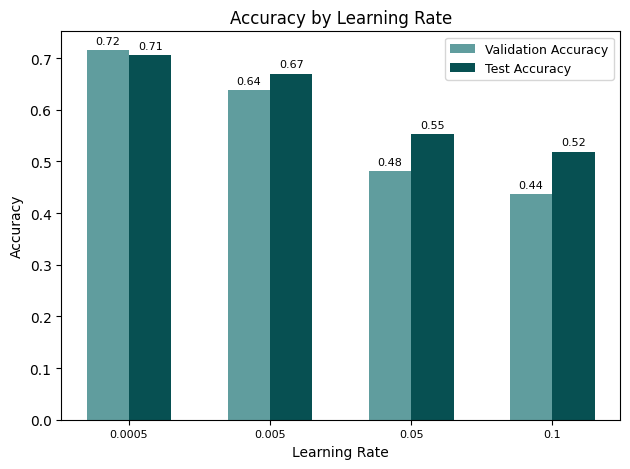

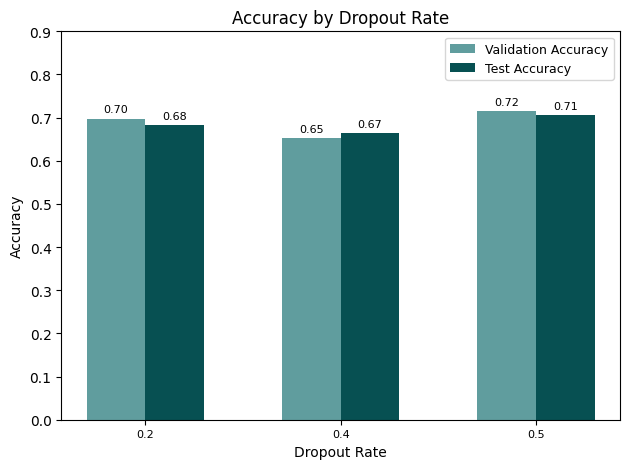

Classification Results pickle file already exists
TP: Name = ['Gordon_Campbell', '1', '2'], Details = {'Predicted Class': 1.0, 'ActualClass': 1.0, 'Probability': 0.9999855756759644}
TN: Name = ['Gordon_Campbell', '1', 'Pierre_Boulanger', '2'], Details = {'Predicted Class': 0.0, 'ActualClass': 0.0, 'Probability': 8.573970688985355e-08}
FP: Name = ['Ismail_Merchant', '1', 'Joseph_Deiss', '1'], Details = {'Predicted Class': 1.0, 'ActualClass': 0.0, 'Probability': 0.9997350573539734}
FN: Name = ['Bono', '1', '3'], Details = {'Predicted Class': 0.0, 'ActualClass': 1.0, 'Probability': 3.010295404237695e-05}


In [ ]:
if __name__ == '__main__':
  run_experiments_and_print_results()